# Psych 250 Final Project 
**Violet Xiang & Emily Kubota**

In [1]:
# import packages 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

First we wanted to ensure that training increased performace accuracy over 10 epochs.

In [2]:
# read in the data 
epoch_overall = pd.read_csv('../results/epoch_results_overall.csv')
epoch_by_label = pd.read_csv('../results/epoch_results_by_label.csv')

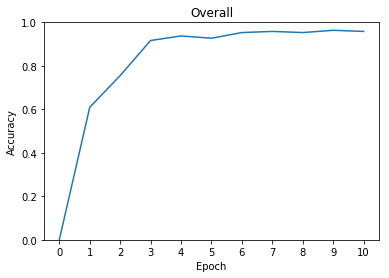

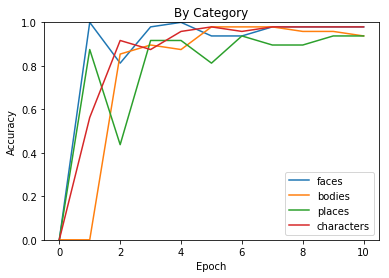

In [3]:
# plot the results overall 

epoch = epoch_overall.epoch[1:12]
accuracy = epoch_overall.accuracy[1:12]

plt.plot(epoch, accuracy)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Overall')
plt.ylim(0, 1)

# plot the results by category 

# first transpose data frame to make it easier work with
df = pd.DataFrame(epoch_by_label)
df = df.T
header_row = 0
df.columns = df.iloc[header_row]
df = df.reset_index(drop=True)
df = df.drop(header_row)
df = df.reset_index(drop=True)

# now we will plot accuracy by epoch for each category 
labels = ["faces","bodies","places","characters"]

fig, ax = plt.subplots()
for i in labels:
    epoch = [*range(0,11,1)] # epochs on x axis 
    accuracy = df[i][1:12] # ignore untrained for now 
    ax.plot(epoch,accuracy)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('By Category')
    ax.set_ylim(0, 1)
    ax.legend()
    

Next, we lesioned our network by randomly lesioning 20% of each layer at each epoch.

In [4]:
# make a dictionary with all of the data 

lesion_overall = pd.DataFrame(columns=['layer', 'accuracy', 'epoch'],dtype=float)

for i in range(11):
    epoch_overall = pd.read_csv('../results/lesion_exp_overall_epoch_'+str(i)+'.csv')
    # first transpose data frame to make it easier work with
    df = pd.DataFrame(epoch_overall)
    df = df.T
    header_row = 0
    df.columns = df.iloc[header_row]
    df = df.reset_index(drop=True)
    df = df.drop(header_row)
    df = df.reset_index(drop=True)
    df = pd.melt(df)
    df['epoch'] = i
    df = df.rename(columns={"Unnamed: 0": "layer", "value": "accuracy"})
    lesion_overall = lesion_overall.append(df, ignore_index=True)

In [5]:
lesion_overall = lesion_overall.astype({'layer': object, 
                'accuracy': float,
                'epoch':int
               } ) 

Overall, lesioning the earliest layer seems to have the least impact on classification. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


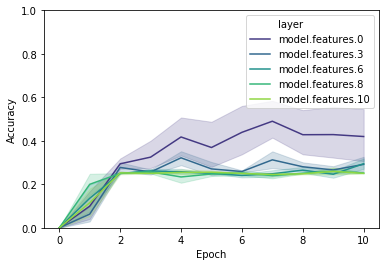

In [6]:
ax = sns.lineplot(x="epoch", y="accuracy",
                 hue="layer", palette="viridis",
                 data=lesion_overall)
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set(ylim = (0,1))
plt.show()

In [7]:
labels = ["faces","bodies","places","characters"]
layers = ["model.features.0","model.features.3","model.features.6","model.features.8","model.features.10"]

data = []
for i in range(11): #epochs 
    epoch = pd.read_pickle("../results/lesion_exp_category_epoch_"+str(i)+".pkl")
    for j in range(10): #experiments 
        exp = epoch["exp_"+str(j)]
        for k in range(5): # layers 
            layer = exp[k]
            for l in labels: # labels 
                accuracy = layer[l]
                data.append([i,j,layers[k],l,accuracy])

                

In [8]:
lesion_by_cat = pd.DataFrame(data, columns=['epoch', 'exp', 'layer','label','accuracy'])

Next, we wanted to check whether lesioning differentially affected classification of our four categories. 

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


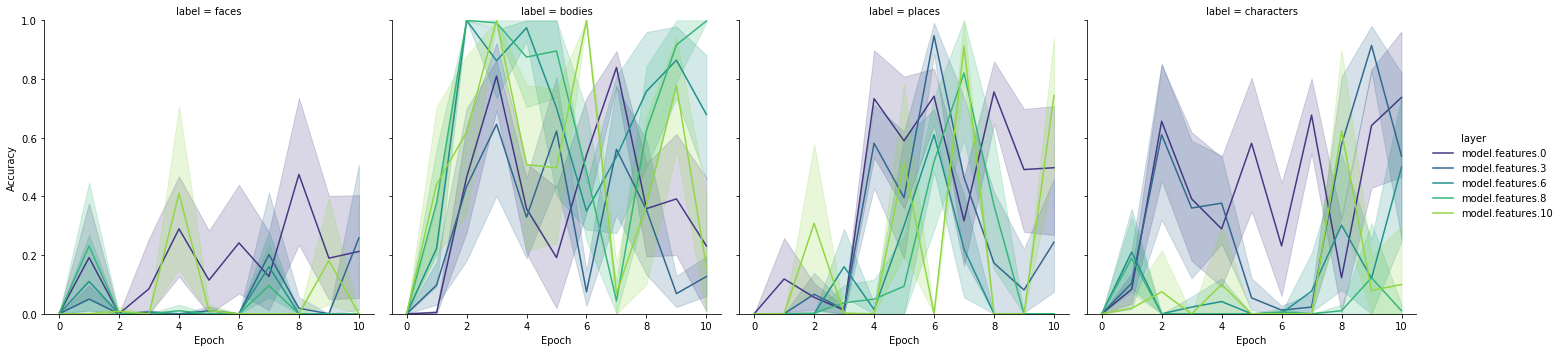

In [9]:
ax = sns.relplot(
    data=lesion_by_cat, x="epoch", y="accuracy",
    col="label", hue="layer",
    kind="line", palette="viridis")
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set(ylim = (0,1))
plt.show()

Collapsing across epochs and layers, face classification was the most impacted by lesioning and body classification was the least impacted.

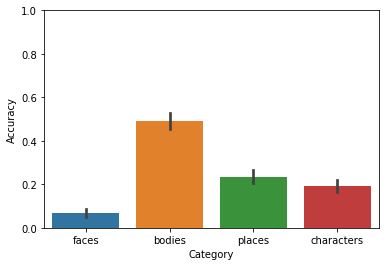

In [14]:
ax = sns.barplot(x="label",y="accuracy", data=lesion_by_cat)
ax.set(ylim = (0,1))
ax.set(xlabel='Category', ylabel='Accuracy')
ax.set(ylim = (0,1))
plt.show()

Lesioning at the first layer impacts acccuracy the least.

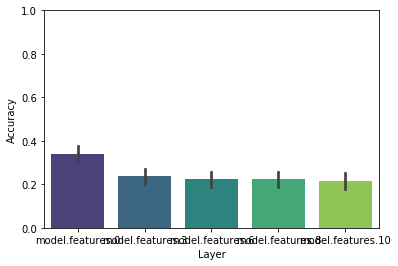

In [15]:
ax = sns.barplot(x="layer",y="accuracy", palette = "viridis", data=lesion_by_cat)
ax.set(ylim = (0,1))
ax.set(xlabel='Layer', ylabel='Accuracy')
ax.set(ylim = (0,1))
plt.show()

Lesioning at the first epoch affects accuracy the most (indicates a 'critical period').

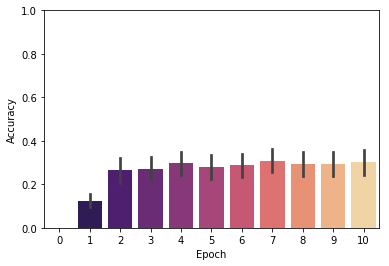

In [16]:
ax = sns.barplot(x="epoch",y="accuracy", palette = "magma", data=lesion_by_cat)
ax.set(ylim = (0,1))
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.set(ylim = (0,1))
plt.show()